In [10]:
import os
import json
import itertools
import random
from collections import Counter
from tqdm import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

from esper.widget import *
import esper.face_embeddings as face_embeddings

def query_faces(ids):
    faces = Face.objects.filter(id__in=ids)
    return faces.values(
        'id', 'bbox_y1', 'bbox_y2', 'bbox_x1', 'bbox_x2',
        'frame__number', 'frame__video__id', 'frame__video__fps',
        'shot__min_frame', 'shot__max_frame')

def query_faces_result(faces, expand_bbox=0.05):
    """Replaces qs_to_result"""
    result = []
    for face in faces:
        if (face.get('shot__min_frame') is not None and
                face.get('shot__max_frame') is not None):
            min_frame = int(
                (face['shot__min_frame'] +
                 face['shot__max_frame']) / 2)
        else:
            min_frame = face['frame__number']
        face_result = {
            'type': 'flat', 'label': '',
            'elements': [{
                'objects': [{
                    'id': face['id'],
                    'background': False,
                    'type': 'bbox',
                    'bbox_y1': max(face['bbox_y1'] - expand_bbox, 0),
                    'bbox_y2': min(face['bbox_y2'] + expand_bbox, 1),
                    'bbox_x1': max(face['bbox_x1'] - expand_bbox, 0),
                    'bbox_x2': min(face['bbox_x2'] + expand_bbox, 1),
                }],
                'min_frame': min_frame,
                'video': face['frame__video__id']
            }]
        }
        result.append(face_result)
    return {'type': 'Face', 'count': 0, 'result': result}

def plot_confusion_matrix(y_truth, y_pred, normalize=True):
    cm = confusion_matrix(y_truth, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = ['Non-black', 'Black']
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Black vs. non-black confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Hand label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_pred_dist(pred):
    n = len(pred)
    counts = Counter([t[1] for t in pred])
    for k in sorted(counts):
        print('', '{:0.2f}'.format(k), counts[k] / n)

In [11]:
with open('/app/data/black.1k.random.json') as f:
    hand_labels_train = {int(k): int(v) for k, v in json.load(f).items()}
train_ids = [i for i in hand_labels_train]
train_y = [hand_labels_train[i] for i in train_ids]
del hand_labels_train
    
with open('/app/data/black.250.random.json') as f:
    hand_labels_test = {int(k): int(v) for k, v in json.load(f).items()}
test_ids = [i for i in hand_labels_test]
test_y = [hand_labels_test[i] for i in test_ids]
del hand_labels_test

Test dist:
 0.00 0.69377990430622
 0.07 0.09617224880382776
 0.13 0.045454545454545456
 0.20 0.022966507177033493
 0.27 0.011004784688995215
 0.33 0.00909090909090909
 0.40 0.005263157894736842
 0.47 0.007177033492822967
 0.53 0.005263157894736842
 0.60 0.004784688995215311
 0.67 0.005263157894736842
 0.73 0.0066985645933014355
 0.80 0.010526315789473684
 0.87 0.010047846889952153
 0.93 0.018660287081339714
 1.00 0.04784688995215311
train dist:
 0.00 0.6997903075489282
 0.07 0.10589468779123952
 0.13 0.04287045666356011
 0.20 0.022833178005591797
 0.27 0.008271202236719477
 0.33 0.008271202236719477
 0.40 0.004543336439888164
 0.47 0.005358807082945014
 0.53 0.005242311276794035
 0.60 0.004193849021435228
 0.67 0.003727865796831314
 0.73 0.006640260950605778
 0.80 0.006756756756756757
 0.87 0.010834109972041006
 0.93 0.019105312208760484
 1.00 0.045666356011183594
Train accuracy: 0.9733224603914259
Train f1-score: 0.8876900441392841
Non-normalized train confusion matrix:


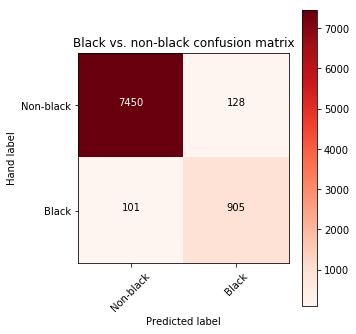

Normalized train confusion matrix:


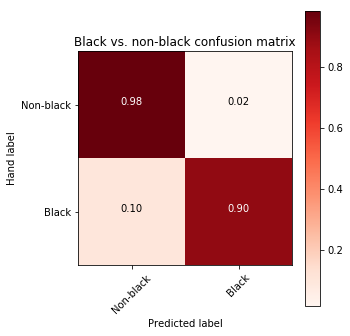

Test accuracy: 0.9631578947368421
Test f1-score: 0.8622540250447227
Non-normalized test confusion matrix:


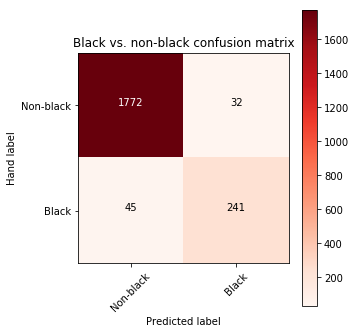

Normalized test confusion matrix:


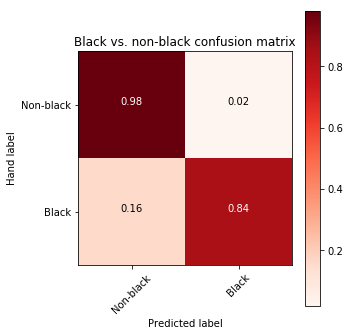

In [12]:
PRED_THRESHOLD = 0.3
K = 15

test_pred_r = face_embeddings.knn_predict(
    train_ids, train_y, k=K, ids=test_ids)
print('Test dist:')
print_pred_dist(test_pred_r)
test_pred_d = {k: 0 if v < PRED_THRESHOLD else 1
               for k, v in test_pred_r}
test_pred = [test_pred_d[i] for i in test_ids]

train_pred_r = face_embeddings.knn_predict(
    train_ids, train_y, k=K, ids=train_ids)
print('train dist:')
print_pred_dist(train_pred_r)
train_pred_d = {k: 0 if v < PRED_THRESHOLD else 1
                for k, v in train_pred_r}
train_pred = [train_pred_d[i] for i in train_ids]

print('Train accuracy:', accuracy_score(train_y, train_pred))
print('Train f1-score:', f1_score(train_y, train_pred))
print('Non-normalized train confusion matrix:')
plot_confusion_matrix(train_y, train_pred, False)
print('Normalized train confusion matrix:')
plot_confusion_matrix(train_y, train_pred)

print('Test accuracy:', accuracy_score(test_y, test_pred))
print('Test f1-score:', f1_score(test_y, test_pred))
print('Non-normalized test confusion matrix:')
plot_confusion_matrix(test_y, test_pred, False)
print('Normalized test confusion matrix:')
plot_confusion_matrix(test_y, test_pred)

# False Positives

In [ ]:
# data_iter = zip(test_ids, test_pred, test_y)
data_iter = zip(train_ids, train_pred, train_y)

fp_ids = [i for i, y_pred, y_true in data_iter
          if y_pred == 1 and y_true == 0]
fp_faces = query_faces(fp_ids)
fp_widget = esper_widget(query_faces_result(fp_faces))
fp_widget

In [ ]:
fp_selected = [fp_faces[i]['id'] for i in fp_widget.selected]
fp_selected

# False Negative

In [ ]:
# data_iter = zip(test_ids, test_pred, test_y)
data_iter = zip(train_ids, train_pred, train_y)

fn_ids = [i for i, y_pred, y_true in data_iter
          if y_pred == 0 and y_true == 1]
fn_faces = query_faces(fn_ids)
fn_widget = esper_widget(query_faces_result(fn_faces))
fn_widget

In [ ]:
fn_selected = [fn_faces[i]['id'] for i in fn_widget.selected]
fn_selected

# Run KNN on Entire Dataset

In [ ]:
RACE_PRED_DIR = '/app/data/race_pred/'
if not os.path.exists(RACE_PRED_DIR):
    os.makedirs(RACE_PRED_DIR)

batch_size = 100000
max_idx = face_embeddings.count()
max_face_id = face_embeddings.ids(max_idx - 1, 1)[0]
# print('Max face id:', max_face_id)
for i in tqdm(range(0, max_face_id, batch_size)):
    batch_face_ids = list(range(i, i + batch_size))
    batch_face_ids = [
        a for a, b in zip(batch_face_ids, face_embeddings.exists(batch_face_ids))
        if b == True
    ]
    batch_pred = face_embeddings.knn_predict(
        train_ids, train_y, k=15, ids=batch_face_ids)
    batch_path = os.path.join(RACE_PRED_DIR, '{}.json'.format(i))
    with open(batch_path, 'w') as f:
        json.dump(batch_pred, f)



  0%|                                                                                                                              | 0/3456 [00:00<?, ?it/s]

  0%|                                                                                                                   | 1/3456 [00:11<11:04:47, 11.54s/it]

  0%|                                                                                                                   | 2/3456 [00:23<11:03:59, 11.53s/it]